This guest post by Dave Cosgrove (GitHub: @DavidACosgrove), is the fifth of a few posts covering some of the new or improved features in the 2023.09.1 RDKit release.

The [Rascal (Rapid Similarity CALculation) algorithm of Raymond et al.](https://eprints.whiterose.ac.uk/3568/1/willets3.pdf) is a rapid way of finding Maximum Common Edge Subgraphs, optimised for chemical structures.  It finds the bonds that are in common between 2 structures, rather than the matching atoms returned by the RDKit's rdFMCS code.  The result is usually, but not always, the same.
Two other differences to the rdFMCS approach are:

1. Rascal will produce a fragmented MCES if relevant
2. Rascal only supports pairs of molecules, while the rdFMCS algorithm supports finding the MCS across an arbitrary number of molecules.


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D, rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdRascalMCES
from rdkit import rdBase
rdDepictor.SetPreferCoordGen(True)
print(rdBase.rdkitVersion)

2023.09.1


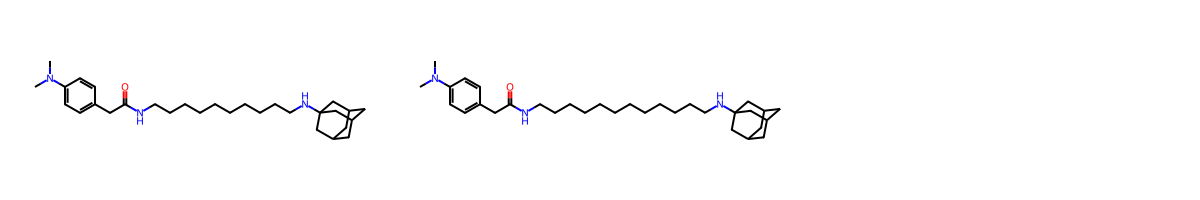

In [2]:
mol1 = Chem.MolFromSmiles('CN(C)c1ccc(CC(=O)NCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1')
mol2 = Chem.MolFromSmiles('CN(C)c1ccc(CC(=O)NCCCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1')
Draw.MolsToGridImage([mol1,mol2],subImgSize=(400,200))

The FindMCES() function returns a list of RascalResult objects that contain the matching bonds and atoms, the SMARTS string for the match and various metrics about the match.

In [3]:
results = rdRascalMCES.FindMCES(mol1, mol2)
res = results[0]
print(f'MCES SMARTS : {res.smartsString}')
print(f'Matching Bonds : {res.bondMatches()}')
print(f'Matching Atoms : {res.atomMatches()}')

MCES SMARTS : CN(-C)-c1:c:c:c(-CC(=O)-NCCCCCCCCCC):c:c:1.NC12CC3CC(-C1)-CC(-C2)-C3
Matching Bonds : [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (21, 23), (22, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32), (31, 33), (32, 34), (33, 35), (34, 36), (35, 37), (36, 38)]
Matching Atoms : [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 23), (22, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32), (31, 33), (32, 34), (33, 35)]


Each pair in the list returned by bondMatches() gives the indices of a bonds in the two molecules that match.  These can be used to highlight the match in a picture.  Here the image uses the Lasso highlighting style, also new in the 2023.09.1 release.

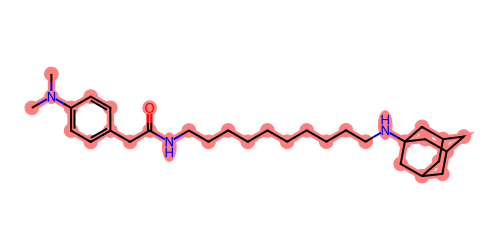

In [9]:
def extractHighlights(res):
    bondHighlights1 = {}
    bondHighlights2 = {}
    for bondPair in res.bondMatches():
        bondHighlights1[bondPair[0]] = [(1.0, 0.0, 0.0)]
        bondHighlights2[bondPair[1]] = [(1.0, 0.0, 0.0)]
    atomHighlights1 = {}
    atomHighlights2 = {}
    for atomPair in res.atomMatches():
        atomHighlights1[atomPair[0]] = [(1.0, 0.0, 0.0)]
        atomHighlights2[atomPair[1]] = [(1.0, 0.0, 0.0)]
    return bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2

def drawMCESMatch(mol1, bondHighlights, atomHighlights):    
    d = rdMolDraw2D.MolDraw2DSVG(500, 250)
    # d.drawOptions().fillHighlights = False
    # d.drawOptions().multiColourHighlightStyle = Draw.MultiColourHighlightStyle.Lasso
    d.DrawMolecule(mol1,highlightAtoms=atomHighlights,highlightBonds=bondHighlights)
    d.FinishDrawing()
    return d


bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2 = extractHighlights(res)
d = drawMCESMatch(mol1, bondHighlights1, atomHighlights1)
SVG(d.GetDrawingText())


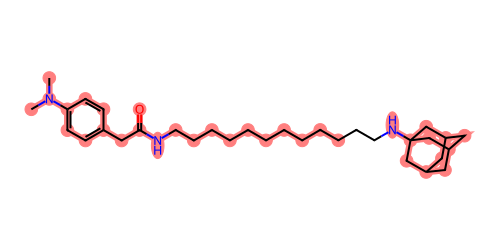

In [10]:
d = drawMCESMatch(mol2, bondHighlights2, atomHighlights2)
SVG(d.GetDrawingText())

There are multiple equally valid MCESs for this pair of molecules, with different breaks in the long chain.  Which one is returned depends on, amongst other things, the input order of the atoms.  It is possible to return all possible results, at the cost of some extra runtime.  The results are returned in a sorted order, with the MCESs with the largest number of bonds first, and other properties used as tie-breakers.

In [11]:
opts = rdRascalMCES.RascalOptions()
opts.allBestMCESs = True
results = rdRascalMCES.FindMCES(mol1, mol2, opts)
print(f'Number of MCESs found : {len(results)}')
print(f'{results[0].smartsString}')
print(f'{results[-1].smartsString}')

Number of MCESs found : 264
CN(-C)-c1:c:c:c(-CC(=O)-NCCCCCCCCCC):c:c:1.NC12CC3CC(-C1)-CC(-C2)-C3
CN(-C)-c1:c:c:c(-CC(=O)-NCCCC):c:c:1.CCCCCCNC12CC3CC(-C1)-CC(-C2)-C3


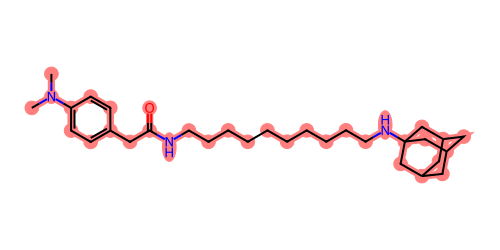

In [12]:
bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2 = extractHighlights(results[-1])
d = drawMCESMatch(mol1, bondHighlights1, atomHighlights1)
SVG(d.GetDrawingText())


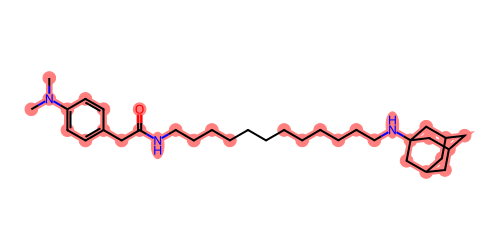

In [13]:
d = drawMCESMatch(mol2, bondHighlights2, atomHighlights2)
SVG(d.GetDrawingText())


If you are only interested in the single largest piece of MCES:

In [14]:
opts = rdRascalMCES.RascalOptions()
opts.singleLargestFrag = True
results = rdRascalMCES.FindMCES(mol1, mol2, opts)
print(f'{results[0].smartsString}')
print(f'Number of MCESs found : {len(results)}')

CN(-C)-c1:c:c:c(-CC(=O)-NCCCCCCCCCC):c:c:1
Number of MCESs found : 1


This is equivalent to the code below, using the RascalResult property largestFragmentSize and the method largestFragmentOnly.  The largestFragmentSize returns the number of atoms in the largest fragment.  Because of the way the results are sorted, the largest fragment may not be in the first result.

In [15]:
opts = rdRascalMCES.RascalOptions()
opts.allBestMCESs = True
results = rdRascalMCES.FindMCES(mol1, mol2, opts)
maxSizeResult = None
maxFragSize = 0
for res in results:
    if res.largestFragmentSize > maxFragSize:
        maxFragSize = res.largestFragmentSize
        maxSizeResult = res
print(f'Largest frag : {maxFragSize}')
print(maxSizeResult.smartsString)
maxSizeResult.largestFragmentOnly()
print(maxSizeResult.smartsString)


Largest frag : 23
CN(-C)-c1:c:c:c(-CC(=O)-NCCCCCCCCCC):c:c:1.NC12CC3CC(-C1)-CC(-C2)-C3
CN(-C)-c1:c:c:c(-CC(=O)-NCCCCCCCCCC):c:c:1


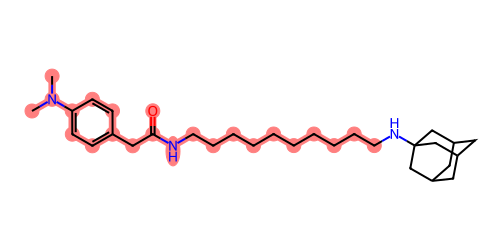

In [16]:
bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2 = extractHighlights(maxSizeResult)
d = drawMCESMatch(mol1, bondHighlights1, atomHighlights1)
SVG(d.GetDrawingText())


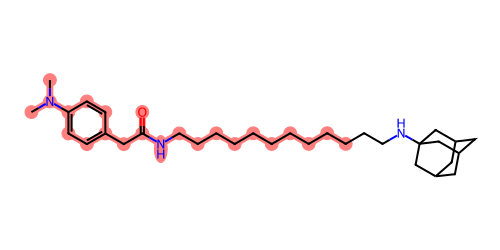

In [17]:
d = drawMCESMatch(mol2, bondHighlights2, atomHighlights2)
SVG(d.GetDrawingText())


## Similarity Threshold
One of the properties in the RascalResult is a measure of the similarity between the 2 molecules based on the MCES, the Johnson similarity:
\begin{equation}
sim=\frac{(E(MCES) + V(MCES))^2}{(E(Mol1) + V(Mol1)) * (E(Mol2) + V(Mol2)}
\end{equation}
where E(MCES) and V(MCES) are the number of edges (bonds) and vertices (atoms) in the MCES, and similarly for molecule 1 and molecule 2.

A key reason for the speed of the algorithm is the use of a similarity threshold as an input parameter.  There are 2 means of estimating upper limits on the final Johnson similarity between the 2 molecules, the first, tier1 similarity, cheaper to calculate than the second, tier2.  If either of these estimates is below the given threshold, then no attempt is made to find an MCES, and an empty list of results is returned.  The default threshold is 0.7, but you can vary that (between 0.0 and 1.0) with the similarityThreshold option.

If you need to know the tier1 and tier2 similarities, you can do:  

In [18]:
ad1 = Chem.MolFromSmiles("CN(C)c1ccc(CC(=O)NCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1 CHEMBL153934")
ad2 = Chem.MolFromSmiles("N(C)c1ccc(CC(=O)NCCCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1 CHEMBL157336")
opts = rdRascalMCES.RascalOptions()
opts.similarityThreshold = 0.95
opts.returnEmptyMCES = True
results = rdRascalMCES.FindMCES(ad1, ad2, opts)
print(results[0].tier1Sim, results[0].tier2Sim)


0.9453984179046884 -1.0


The tier1 similarity is 0.94, so the tier2 isn't calculated (hence the -1).  None of the rest of the results fields will contain anything.

## Clustering
  The Johnson similarity measure can be used for clustering.  [Raymond and Willett have described a fuzzy clustering method](https://eprints.whiterose.ac.uk/77598/) that uses the Johnson similarity between the MCESs of pairs of compounds.

In [19]:
import os
from pathlib import Path
cdk2_file = Path(os.environ['RDBASE']) / 'Contrib' / 'Fastcluster' / 'cdk2.smi'
suppl = Chem.SmilesMolSupplier(str(cdk2_file), '\t', 1, 0, False)
mols = [mol for mol in suppl]
clusters = rdRascalMCES.RascalCluster(mols)
print(clusters)

[[3, 4, 1, 2, 0, 28, 29], [25, 26, 38, 24, 46, 39, 27], [6, 34, 35, 7, 5, 44], [36, 44], [13, 14], [19, 20], [21, 22], [16, 18, 17, 10, 23, 32, 30, 15, 33, 31, 9, 37, 42, 12, 11, 8, 40, 41, 43, 45]]


The clusters are returned as lists of indices into the original list of molecules.  The final cluster is all the singletons that didn't fit into another cluster.  

This is a fuzzy clustering approach, so it's possible for molecules to be in more than one cluster:

In [20]:
from collections import defaultdict
clustMembership = defaultdict(list)
for ci,c in enumerate(clusters):
    for ai in c:
        clustMembership[ai].append(ci)

for ai in clustMembership:
    if len(clustMembership[ai])>1:
        print(ai,clustMembership[ai])

44 [2, 3]


In [21]:
%timeit clusters = rdRascalMCES.RascalCluster(mols)

78.3 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


If you prefer a more conventional, non-fuzzy clustering method, then there is an implementation of the Butina algorithm, also using the Johnson similarity as the metric.

In [22]:
clusters = rdRascalMCES.RascalButinaCluster(mols)
print(clusters)

[[25, 26, 38, 24, 27, 46], [6, 34, 5, 35, 44, 7], [4, 3, 1, 2, 0, 28], [22, 21], [20, 19], [14, 13], [45], [43], [42], [41], [40], [39], [37], [36], [33], [32], [31], [30], [29], [23], [18], [17], [16], [15], [12], [11], [10], [9], [8]]


In this case, the singletons are left in separate clusters.

In [23]:
%timeit clusters = rdRascalMCES.RascalButinaCluster(mols)

47.8 ms ± 853 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Both the RascalCluster and RascalButinaCluster methods can take an optional class changing the default options:

In [24]:
clusOpts = rdRascalMCES.RascalClusterOptions()
clusOpts.similarityCutoff = 0.6
clusters = rdRascalMCES.RascalButinaCluster(mols, clusOpts)
print(clusters)

[[4, 3, 1, 2, 0, 28, 8, 29], [44, 6, 36, 34, 5, 35, 7], [25, 26, 38, 24, 27, 46, 40], [42, 10], [32, 30], [22, 21], [20, 19], [17, 16], [14, 13], [45], [43], [41], [39], [37], [33], [31], [23], [18], [15], [12], [11], [9]]


In [25]:
%timeit clusters = rdRascalMCES.RascalButinaCluster(mols, clusOpts)

201 ms ± 8.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Acknowledgements

This work was funded by Glysade LLC (mstahl@glysade.com).

Credit is also due to John Raymond for his original paper which, whilst appearing impenetrable at first (and second, and third) glance, does contain all the information necessary for a full implementation.